In [1]:
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import time as time
import numpy as np
from IPython import display

In [160]:
seed = 123
x = np.random.randint(256, size=(4096,12))
sumi= np.array(np.sum(x,axis=1)%2)
X = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(sumi)

In [161]:
BATCH_SIZE = 256
device = "cuda" if torch.cuda.is_available() else "cpu"
dataloader = DataLoader(list(zip(X,y)), batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())

In [162]:
dataloader

In [163]:
device

'cuda'

In [164]:
dataloader_whole = DataLoader(list(zip(X,y)), batch_size=4096, shuffle=False, num_workers=os.cpu_count())
NUM_LABELS = 2
labelixs = {}
for _,label in dataloader_whole:

  for i in range(NUM_LABELS):
    labelixs[i] = (label%2) == i




In [165]:
class block(nn.Module):

  def __init__(self, input_cha, output_cha, activation = "tanh"):
    super().__init__()

    if activation=="tanh":
      self.model = nn.Sequential(
          nn.Linear(input_cha, output_cha),
          nn.Tanh()
      )
    else:
      self.model = nn.Sequential(
          nn.Linear(input_cha, output_cha),
          nn.ReLU()
      )

  def forward(self, x):
        y = self.model(x)
        return y


class cnn(nn.Module):

   def __init__(self, activation):
    super().__init__()
    self.l2 = block(12, 10, activation)
    self.l3 = block(10, 7,activation)
    self.l4 = block(7,5, activation)
    self.l5 = block(5,4, activation)
    self.l6 = block(4,3, activation)
    self.l7 = block(3,2, activation)
    self.sig = nn.Sigmoid()
   def forward(self,input):
    l2 = self.l2(input)
    l3 = self.l3(l2)
    l4 = self.l4(l3)
    l5 = self.l5(l4)
    l6 = self.l6(l5)
    l7 = self.l7(l6)
    sig = self.sig(l7)
    return sig,l2,l3,l4,l5,l6,l7

In [166]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.xavier_uniform_(m.weight.data)
    if classname.find('Linear') != -1:
        #nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.xavier_uniform_(m.weight.data)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.2)
        nn.init.constant_(m.bias.data, 0)

In [167]:
cnn_tanh = cnn("tanh").to(device)
cnn_tanh.apply(weights_init)

cnn(
  (l2): block(
    (model): Sequential(
      (0): Linear(in_features=12, out_features=10, bias=True)
      (1): Tanh()
    )
  )
  (l3): block(
    (model): Sequential(
      (0): Linear(in_features=10, out_features=7, bias=True)
      (1): Tanh()
    )
  )
  (l4): block(
    (model): Sequential(
      (0): Linear(in_features=7, out_features=5, bias=True)
      (1): Tanh()
    )
  )
  (l5): block(
    (model): Sequential(
      (0): Linear(in_features=5, out_features=4, bias=True)
      (1): Tanh()
    )
  )
  (l6): block(
    (model): Sequential(
      (0): Linear(in_features=4, out_features=3, bias=True)
      (1): Tanh()
    )
  )
  (l7): block(
    (model): Sequential(
      (0): Linear(in_features=3, out_features=2, bias=True)
      (1): Tanh()
    )
  )
  (sig): Sigmoid()
)

In [168]:
from torchsummary import summary
summary(cnn_tanh,input_size = (1,12), batch_size = 256, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [256, 1, 10]             130
              Tanh-2               [256, 1, 10]               0
             block-3               [256, 1, 10]               0
            Linear-4                [256, 1, 7]              77
              Tanh-5                [256, 1, 7]               0
             block-6                [256, 1, 7]               0
            Linear-7                [256, 1, 5]              40
              Tanh-8                [256, 1, 5]               0
             block-9                [256, 1, 5]               0
           Linear-10                [256, 1, 4]              24
             Tanh-11                [256, 1, 4]               0
            block-12                [256, 1, 4]               0
           Linear-13                [256, 1, 3]              15
             Tanh-14                [25

In [169]:
loss = nn.CrossEntropyLoss()

In [170]:
opt = torch.optim.SGD(cnn_tanh.parameters(), lr=0.01, momentum = 0.9)

In [171]:
def train_step(images, label, cnn, BATCH_SIZE, opt):

    prob,l2_out,l3_out,l4_out ,l5_out,l6_out,l7_out= cnn(images)
    label_n = label.to(device)
    cnn_loss = loss(prob, label_n)
    opt.zero_grad()
    cnn_loss.backward()
    opt.step()
    return cnn_loss, prob,l2_out,l3_out,l4_out,l5_out,l6_out,l7_out


In [172]:
from sklearn.metrics import accuracy_score

In [173]:
# Simplified MI computation code from https://github.com/ravidziv/IDNNs
import numpy as np


def get_unique_probs(x):
    uniqueids = np.ascontiguousarray(x)#.view(np.dtype((np.void, x.dtype.itemsize * x.shape[1])))
    _, unique_inverse, unique_counts = np.unique(uniqueids, return_index=False, return_inverse=True, return_counts=True)
    return np.asarray(unique_counts / float(sum(unique_counts))), unique_inverse


def bin_calc_information(inputdata, layerdata, num_of_bins):
    p_xs, unique_inverse_x = get_unique_probs(inputdata)

    bins = np.linspace(-1, 1, num_of_bins, dtype='float32')
    digitized = bins[np.digitize(np.squeeze(layerdata.reshape(1, -1)), bins) - 1].reshape(len(layerdata), -1)
    p_ts, _ = get_unique_probs(digitized)

    H_LAYER = -np.sum(p_ts * np.log(p_ts))
    H_LAYER_GIVEN_INPUT = 0.
    for xval in np.arange(len(p_xs)):
        p_t_given_x, _ = get_unique_probs(digitized[unique_inverse_x == xval, :])
        H_LAYER_GIVEN_INPUT += - p_xs[xval] * np.sum(p_t_given_x * np.log(p_t_given_x))
    return H_LAYER - H_LAYER_GIVEN_INPUT


def bin_calc_information2(labelixs, layerdata, binsize):
    # This is even further simplified, where we use np.floor instead of digitize
    def get_h(d):
        digitized = np.floor(d / binsize).astype('int')
        p_ts, _ = get_unique_probs(digitized)

        return -np.sum(p_ts * np.log(p_ts))

    H_LAYER = get_h(layerdata)
    H_LAYER_GIVEN_OUTPUT = 0
    for label, ixs in labelixs.items():
        b = ixs.long()
        b = np.array(b)
              #print(H_LAYER_GIVEN_OUTPUT)
        H_LAYER_GIVEN_OUTPUT += b.mean() * get_h(layerdata[ixs, :])

    return H_LAYER, H_LAYER - H_LAYER_GIVEN_OUTPUT

In [176]:

mi_data = {0: {}, 1: {}, 2: {}, 3: {}, 4:{},5:{}}  # 0 for L1 and 1 for L2

activities = [np.zeros((4096, 10)),
              np.zeros((4096 ,7)),
              np.zeros((4096 ,5)),
              np.zeros((4096 ,4)),
              np.zeros((4096 ,3)),
              np.zeros((4096 ,2))]

for layer_no in range(6):
    mi_data[layer_no]['full'] = []
    for f in range(activities[layer_no].shape[1]):
        mi_data[layer_no][f'F{f + 1}'] = []

def train(dataloader, epochs, cnn, BATCH_SIZE, opt):
  loss_list = []
  acc_list = []
  for epoch in range(epochs):
    losses = []
    conc_out = []
    conc_label = []
    i=0
    print(epoch)
    for image_batch, label in dataloader:
        image_batch = image_batch.to(device)
        cnn_loss, prob,l2_out,l3_out,l4_out,l5_out,l6_out,l7_out = train_step(image_batch,label, cnn, BATCH_SIZE, opt)
        # for num in range(100):

        activities[0][i:i+256]=l2_out.detach().cpu().numpy()
        activities[1][i:i+256]=l3_out.detach().cpu().numpy()
        activities[2][i:i+256]=l4_out.detach().cpu().numpy()
        activities[3][i:i+256]=l5_out.detach().cpu().numpy()
        activities[4][i:i+256]=l6_out.detach().cpu().numpy()
        activities[5][i:i+256]=l7_out.detach().cpu().numpy()

        i+=256

        losses.append(cnn_loss.detach().cpu().item())
        conc_out.append(prob.detach().cpu())
        conc_label.append(label.detach().cpu())

    for idx, layer in enumerate(activities):
        layer_full = np.array(layer)
        mi_data[idx]['full'].append(bin_calc_information2(labelixs, layer_full, 0.006))
    conc_out = torch.cat(conc_out)
    conc_label = torch.cat(conc_label)
    acc = accuracy_score(conc_label, conc_out.argmax(axis=1))
    loss_list.append(np.mean(losses))
    acc_list.append(acc)
  return loss_list , acc_list

In [177]:
epochs=20
loss_list, acc_list = train(dataloader,epochs, cnn_tanh, BATCH_SIZE, opt)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [179]:
l1= np.array(mi_data[0]['full'])
l2= np.array(mi_data[1]['full'])
l3= np.array(mi_data[2]['full'])
l4= np.array(mi_data[3]['full'])
l5= np.array(mi_data[4]['full'])
l6= np.array(mi_data[5]['full'])


len(l4)

20

In [ ]:
from numpy import savetxt

savetxt('l1-tanh.csv', l1, delimiter=',')


In [ ]:
savetxt('l2-tanh.csv', l2, delimiter=',')
savetxt('l3-tanh.csv', l3, delimiter=',')
savetxt('l4-tanh.csv', l4, delimiter=',')
savetxt('l5-tanh.csv', l5, delimiter=',')
savetxt('l6-tanh.csv', l6, delimiter=',')
savetxt('l7-tanh.csv', l7, delimiter=',')

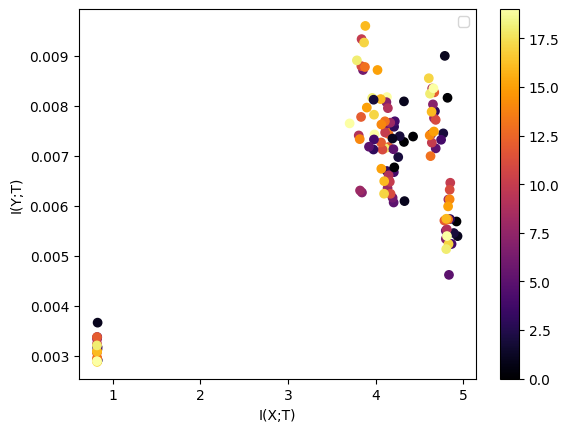

In [180]:
t = np.arange(len(l1[:, 0]))
plt.scatter(l1[:,0],l1[:,1],c=t, cmap='inferno')
plt.scatter(l2[:,0],l2[:,1],c=t, cmap='inferno')
plt.scatter(l3[:,0],l3[:,1],c=t, cmap='inferno')
plt.scatter(l4[:,0],l4[:,1],c=t, cmap='inferno')
plt.scatter(l5[:,0],l5[:,1],c=t, cmap='inferno')
plt.scatter(l6[:,0],l6[:,1],c=t, cmap='inferno')

# for i in range(30):
#   plt.plot((l1[i,0],l1[i,1]),(l2[i,0],l2[i,1]),(l3[i,0],l3[i,1]))
plt.xlabel('I(X;T)')
plt.ylabel('I(Y;T)')

plt.colorbar()

plt.legend()
plt.show()

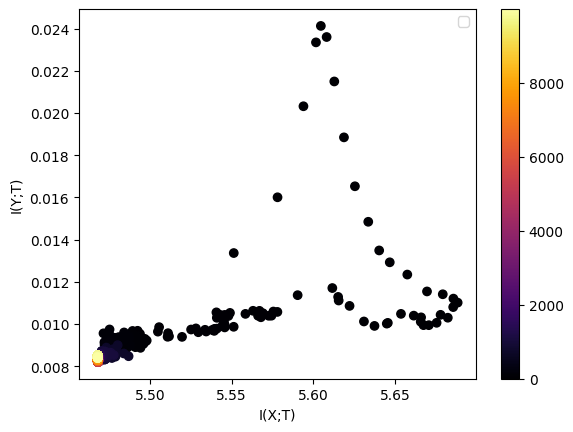

In [ ]:
t = np.arange(len(l1[:, 0]))
plt.scatter(l1[:,0],l1[:,1],c=t, cmap='inferno')

plt.xlabel('I(X;T)')
plt.ylabel('I(Y;T)')

plt.colorbar()

plt.legend()
plt.show()

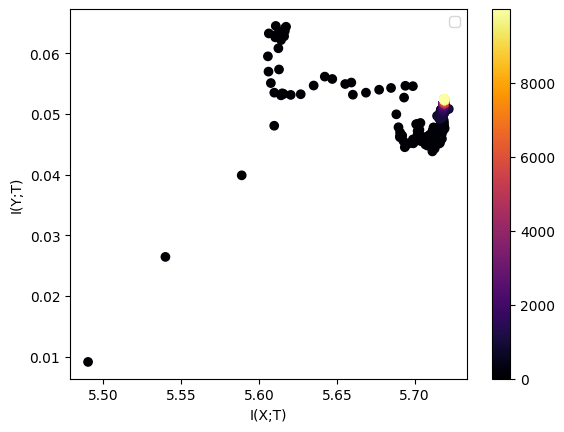

In [ ]:
t = np.arange(len(l1[:, 0]))
plt.scatter(l2[:,0],l2[:,1],c=t, cmap='inferno')
# for i in range(30):
#   plt.plot((l1[i,0],l1[i,1]),(l2[i,0],l2[i,1]),(l3[i,0],l3[i,1]))
plt.xlabel('I(X;T)')
plt.ylabel('I(Y;T)')

plt.colorbar()

plt.legend()
plt.show()

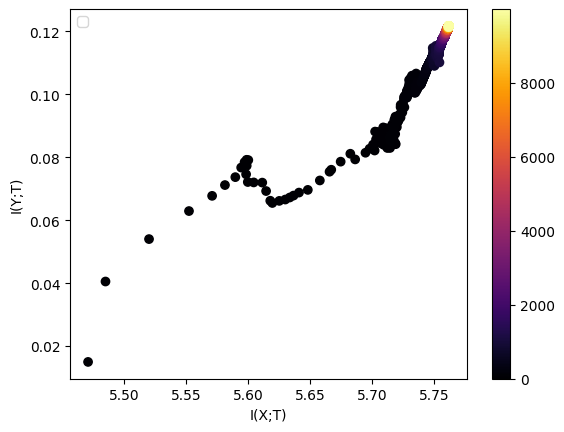

In [ ]:
t = np.arange(len(l1[:, 0]))

plt.scatter(l3[:,0],l3[:,1],c=t, cmap='inferno')
# for i in range(30):
#   plt.plot((l1[i,0],l1[i,1]),(l2[i,0],l2[i,1]),(l3[i,0],l3[i,1]))

plt.xlabel('I(X;T)')
plt.ylabel('I(Y;T)')
plt.colorbar()

plt.legend()
plt.show()

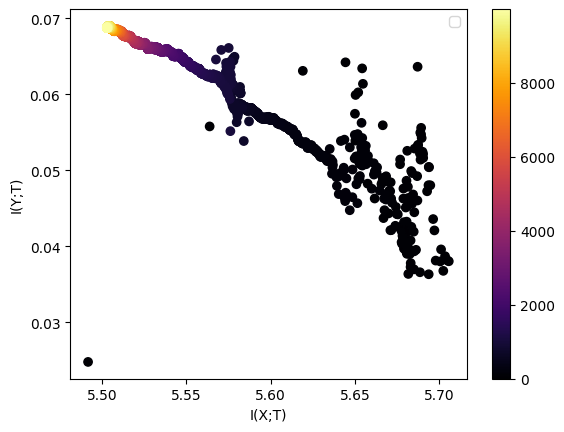

In [ ]:
t = np.arange(len(l1[:, 0]))

plt.scatter(l4[:,0],l4[:,1],c=t, cmap='inferno')
# for i in range(30):
#   plt.plot((l1[i,0],l1[i,1]),(l2[i,0],l2[i,1]),(l3[i,0],l3[i,1]))
plt.xlabel('I(X;T)')
plt.ylabel('I(Y;T)')

plt.colorbar()

plt.legend()
plt.show()

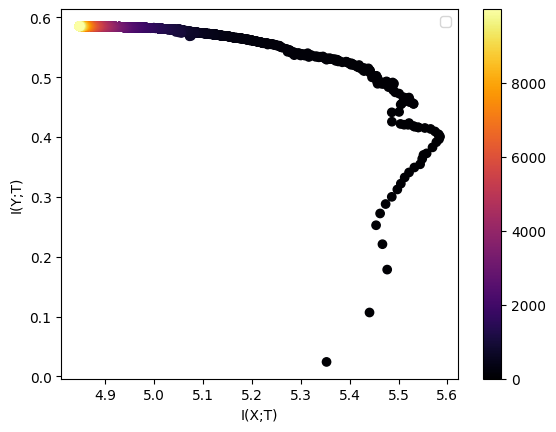

In [ ]:
t = np.arange(len(l1[:, 0]))

plt.scatter(l5[:,0],l5[:,1],c=t, cmap='inferno')
# for i in range(30):
#   plt.plot((l1[i,0],l1[i,1]),(l2[i,0],l2[i,1]),(l3[i,0],l3[i,1]))

plt.xlabel('I(X;T)')
plt.ylabel('I(Y;T)')
plt.colorbar()

plt.legend()
plt.show()

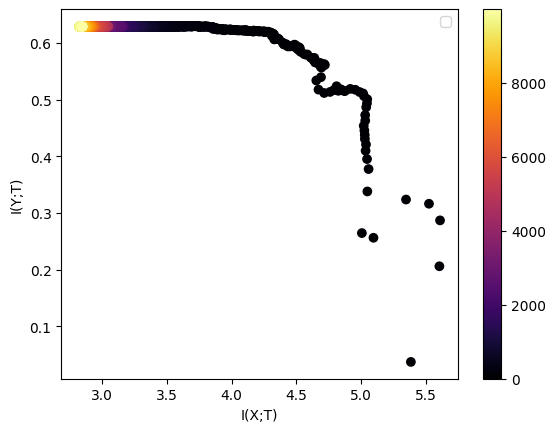

In [ ]:
t = np.arange(len(l1[:, 0]))

plt.scatter(l6[:,0],l6[:,1],c=t, cmap='inferno')
# for i in range(30):
#   plt.plot((l1[i,0],l1[i,1]),(l2[i,0],l2[i,1]),(l3[i,0],l3[i,1]))
plt.xlabel('I(X;T)')
plt.ylabel('I(Y;T)')

plt.colorbar()

plt.legend()
plt.show()

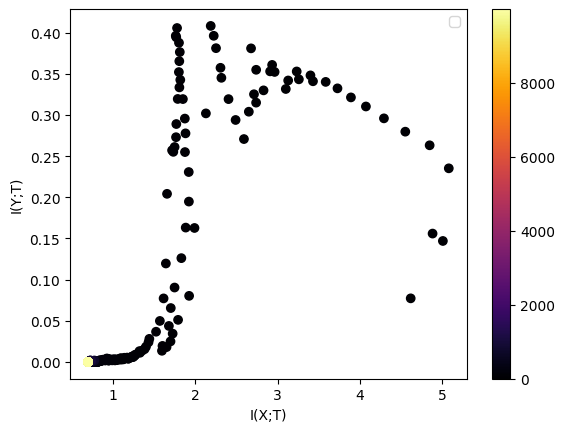

In [ ]:
t = np.arange(len(l1[:, 0]))

plt.scatter(l7[:,0],l7[:,1],c=t, cmap='inferno')
# for i in range(30):
#   plt.plot((l1[i,0],l1[i,1]),(l2[i,0],l2[i,1]),(l3[i,0],l3[i,1]))

plt.xlabel('I(X;T)')
plt.ylabel('I(Y;T)')
plt.colorbar()

plt.legend()
plt.show()

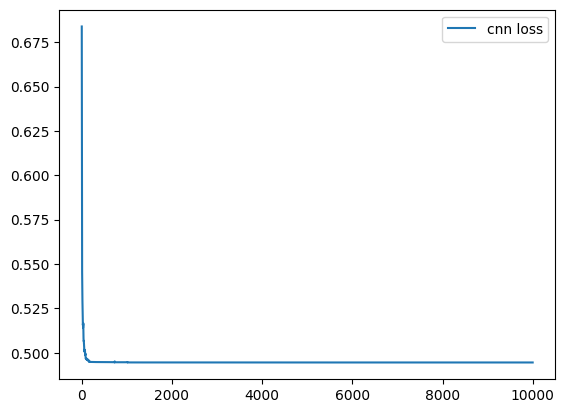

In [ ]:
# plt.figure(figsize=(10,10))
plt.plot(loss_list, label="cnn loss")
plt.legend()
plt.show()
savetxt('loss-tanh.csv', loss_list, delimiter=',')

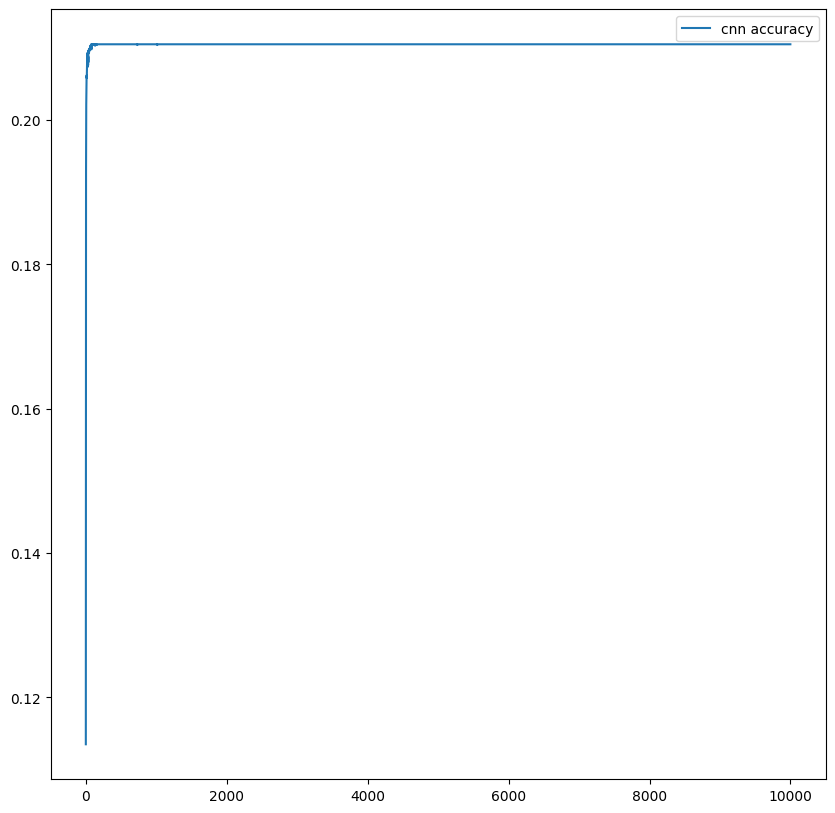

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(acc_list, label="cnn accuracy")
plt.legend()
plt.show()
savetxt('acc-tanh.csv', acc_list, delimiter=',')

In [ ]:
mi_data = {0: {}, 1: {}, 2: {}, 3: {}}  # 0 for L1 and 1 for L2

activities = [np.zeros((1000, 4, 10304)),
              np.zeros((1000, 8, 2576)),
              np.zeros((1000,8, 648)),
              np.zeros((1000, 16, 164))]

for layer_no in range(4):
    mi_data[layer_no]['full'] = []
    for f in range(activities[layer_no].shape[1]):
        mi_data[layer_no][f'F{f + 1}'] = []

In [ ]:
 len(activities[0])

8

In [ ]:
mi_data

{0: {'full': [], 'F1': [], 'F2': [], 'F3': [], 'F4': []},
 1: {'full': [],
  'F1': [],
  'F2': [],
  'F3': [],
  'F4': [],
  'F5': [],
  'F6': [],
  'F7': [],
  'F8': []},
 2: {'full': [],
  'F1': [],
  'F2': [],
  'F3': [],
  'F4': [],
  'F5': [],
  'F6': [],
  'F7': [],
  'F8': []},
 3: {'full': [],
  'F1': [],
  'F2': [],
  'F3': [],
  'F4': [],
  'F5': [],
  'F6': [],
  'F7': [],
  'F8': [],
  'F9': [],
  'F10': [],
  'F11': [],
  'F12': [],
  'F13': [],
  'F14': [],
  'F15': [],
  'F16': []}}

In [ ]:
# for idx, layer in enumerate(activities):
#   print(layer)

In [ ]:
for image_batch, label in dataloader:
  la = label


In [ ]:
la

tensor([8, 3, 6, 1, 7, 3, 5, 0, 1, 8, 4, 0, 4, 8, 1, 6])

In [ ]:
NUM_LABELS = 10
labelixs = {}
for i in range(NUM_LABELS):
  labelixs[i] = la == i
print(labelixs)

{0: tensor([False, False, False, False, False, False, False,  True, False, False,
        False,  True, False, False, False, False]), 1: tensor([False, False, False,  True, False, False, False, False,  True, False,
        False, False, False, False,  True, False]), 2: tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False]), 3: tensor([False,  True, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False]), 4: tensor([False, False, False, False, False, False, False, False, False, False,
         True, False,  True, False, False, False]), 5: tensor([False, False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False]), 6: tensor([False, False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False,  True]), 7: tensor([False, False, False, False,  True, False, False, False, F

In [ ]:
H_LAYER_GIVEN_OUTPUT=0


  print(b.mean())


0.125
0.1875
0.0
0.125
0.125
0.0625
0.125
0.0625
0.1875
0.0
